In [1]:
import numpy
import h5py
import pandas

from toposample import Config, data
from figure_helper import FigureHelper
from helper_functions import Percentile, Normalizer
from pandas_helper import column_names_to_values
from toposample.db import get_column_from_database
from toposample.data import read_h5_dataset

"""
Main config file. This file specifies the paths to all the result files and allows us to read the results.
"""
cfg = Config("../working_dir/config/common_config.json")

"""
Additional parameterization, like which examples to plot and in which color
"""
# Order in which to plot the results
spec_parameters = ['Relative boundary', 'Fourth density coefficient',
              'Fifth density coefficient', 'Chung spectrum', 'Transitive clustering coefficient',
              'Adjacency spectral gap (low)', 'Afferent extension rate',
              'Normalized Betti coefficient', 'Out-degree', 'Second density coefficient',
              'Euler characteristic']
spec_comm_coupling = ['Community coupling', 'Mean tribe community coupling']

"""
To save plots in standardized locations, i.e. under ./figures
"""
fhlpr = FigureHelper()
F = fhlpr("Figure 4")
S = fhlpr("Figure S4")
F5 = fhlpr("Figure 5")

In [2]:
"""
Files we are going to load
"""
tribe_struc_params_fn = cfg._cfg['analyzed']['struc_parameters']
tribe_triads_fn = cfg._cfg['analyzed']['triads']
tribe_gids_fn = cfg._cfg['analyzed']['tribes']
db_fn = cfg._cfg['analyzed']['database']
tribe_accuracy_fn = cfg._cfg['analyzed']['classifier_components_results']

"""
Load the data
"""
acc_reader = read_h5_dataset("scores")  # Loading function to extract the accuracy

tribe_struc_params = data.TopoData(tribe_struc_params_fn)
tribe_triads = data.TopoData(tribe_triads_fn)['overexpression'].map(numpy.array)
tribe_gids = data.TopoData(tribe_gids_fn)['gids']
db = pandas.read_pickle(db_fn)
data_acc = data.TopoData(tribe_accuracy_fn, follow_link_functions={"data_fn": (acc_reader, True)})['data_fn']
param_definitions = cfg.stage("struc_tribe_analysis")["config"]["Parameters"]


In [3]:
"""
Some basic analysis that will help in the future.
"""
#  We sort the order of parameters by their accuracy in the manifold task
tribe_pooled_acc = data_acc.pool(["index"], func=numpy.hstack)
tribe_mean_acc = tribe_pooled_acc.map(numpy.nanmean)
tribe_sd_acc = tribe_pooled_acc.map(numpy.nanstd)
idxx = numpy.argsort([tribe_mean_acc.get2(sampling="Parameter", specifier=spec)
                      for spec in spec_parameters])
spec_parameters = [spec_parameters[i] for i in idxx]

# Add the size of the associated tribe as a structural parameter
tribe_size = tribe_gids.map(len)
tribe_struc_params.data["Tribe size"] = tribe_size

# override one specific parameter that is not properly calculated for volumetric samples
tribe_struc_params.data["Mean tribe community coupling"] =\
tribe_gids.map(lambda x: numpy.nanmean(db["comm_coupling"].loc[x]))

#  Helper function: For a given parameter find all its "subsampled" versions and return them in order
def find_subsampled(base_parameter, data_struc=None):
    if data_struc is None:
        data_struc = data_acc
    subs_specs = data_struc.filter(sampling="subsampled").labels_of("specifier")
    ret_x = []
    ret_specs = []
    for spec in subs_specs:
        spec_name, spec_val = spec.split("@")
        if spec_name != base_parameter:
            continue
        ret_x.append(int(spec_val))
        ret_specs.append(spec)
    idxx = numpy.argsort(ret_x)
    return [ret_x[i] for i in idxx], [ret_specs[i] for i in idxx]


<ipython-input-3-46a5c4c43f4f>:18: RuntimeWarning: Mean of empty slice
  tribe_gids.map(lambda x: numpy.nanmean(db["comm_coupling"].loc[x]))


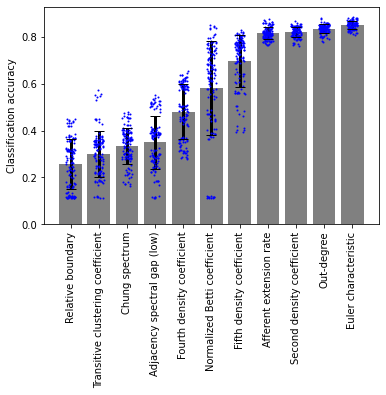

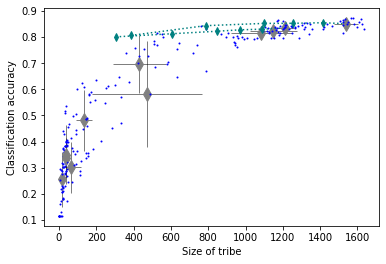

In [5]:
"""
Figure panel: Accuracies for the champions of the various parameters
"""
from matplotlib import pyplot as plt

plot_mean_acc = [tribe_mean_acc.get2(sampling="Parameter", specifier=spec)
                for spec in spec_parameters]
plot_sd_acc = [tribe_sd_acc.get2(sampling="Parameter", specifier=spec)
               for spec in spec_parameters]

fig = plt.figure()
ax = fig.gca()

ax.bar(range(len(plot_mean_acc)), plot_mean_acc, color='grey')
for x, spec in enumerate(spec_parameters):
    y = tribe_pooled_acc.get2(sampling="Parameter", specifier=spec)
    ax.plot(x + 0.35 * (numpy.random.rand(len(y)) - 0.5), y, marker='.', ms=2, color='blue', ls='None')
ax.errorbar(range(len(plot_mean_acc)), plot_mean_acc, yerr=plot_sd_acc,
            ls='None', color='black', elinewidth=3, capsize=5)
    
ax.set_xticks(range(len(spec_parameters)))
_ = ax.set_xticklabels(spec_parameters, rotation='vertical')
ax.set_ylabel("Classification accuracy")

F.save(fig, fn="Panel-A")

"""
Figure panel: Accuracies vs. sizes of the tribes
"""
fig = plt.figure()
ax = fig.gca()

# averages the accuracy of cross-val. iterations, but not across champions of a parameter
tribe_nonpooled_mean_acc = data_acc.map(numpy.nanmean)
tribe_mean_size = tribe_size.pool(["index"], func=numpy.mean)
for spec in spec_parameters:
    index, x = tribe_size.get_x_y("index", sampling="Parameter", specifier=spec)
    mean_x = tribe_mean_size.get2(sampling="Parameter", specifier=spec)
    y = [tribe_nonpooled_mean_acc.get2(sampling="Parameter", specifier=spec, index=idx) for idx in index]
    mean_y = tribe_mean_acc.get2(sampling="Parameter", specifier=spec)
    
    _, subs_spec = find_subsampled(spec)
    if len(subs_spec):
        subs_x = [tribe_mean_size.get2(sampling="subsampled", specifier=_spec) for _spec in subs_spec]
        subs_y = [tribe_mean_acc.get2(sampling="subsampled", specifier=_spec) for _spec in subs_spec]
        ax.plot(subs_x + [mean_x], subs_y + [mean_y], color="teal", marker="d", ms=5, ls=":")

    ax.plot(mean_x, mean_y, ls="None", marker="d", ms=10, color='grey')
    ax.errorbar(mean_x, mean_y, xerr=numpy.std(x), yerr=numpy.std(y), lw=0.5, color='black')
    ax.plot(x, y, ls="None", marker='.', ms=2, color='blue')
    ax.set_xlabel("Size of tribe")
    ax.set_ylabel("Classification accuracy")

F.save(fig, fn="Panel-B")

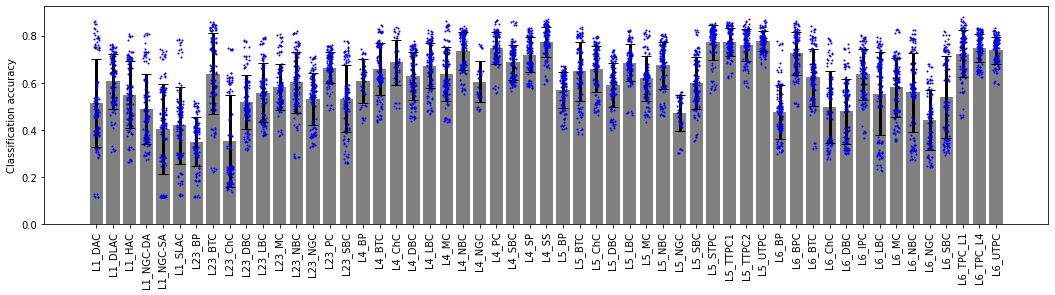

In [6]:
"""
Figure panel: Accuracies for the randomly sampled tribes
"""
spec_mtypes = tribe_mean_acc.filter(sampling="M-type").labels_of("specifier")
plot_mean_acc = [tribe_mean_acc.get2(sampling="M-type", specifier=spec)
                for spec in spec_mtypes]
plot_sd_acc = [tribe_sd_acc.get2(sampling="M-type", specifier=spec)
               for spec in spec_mtypes]

fig = plt.figure(figsize=(18, 4))
ax = fig.gca()

ax.bar(range(len(plot_mean_acc)), plot_mean_acc, color='grey')
for x, spec in enumerate(spec_mtypes):
    y = tribe_pooled_acc.get2(sampling="M-type", specifier=spec)
    ax.plot(x + 0.35 * (numpy.random.rand(len(y)) - 0.5), y, marker='.', ms=2, color='blue', ls='None')
ax.errorbar(range(len(plot_mean_acc)), plot_mean_acc, yerr=plot_sd_acc,
            ls='None', color='black', elinewidth=3, capsize=5)
    
ax.set_xticks(range(len(spec_mtypes)))
_ = ax.set_xticklabels(spec_mtypes, rotation='vertical')
ax.set_ylabel("Classification accuracy")

S.save(fig, fn="Panel-A")

,specifier,Accuracy,Relative_boundary,Transitive_clustering_coefficient,Chung_spectrum,Adjacency_spectral_gap_low,Fourth_density_coefficient,Normalized_Betti_coefficient,Fifth_density_coefficient,Afferent_extension_rate,Second_density_coefficient,Outdegree,Euler_characteristic,Tribe_size
0,L23_MC,0.669818,26.3750,0.0295,0.2936,0.019400,4.314920e-07,0.0766,0.0,22766.0,0.000031,668.0,467.0,719
1,L23_MC,0.519281,61.6815,0.0382,0.1654,0.000141,0.000000e+00,0.1125,0.0,13552.0,0.000011,137.0,26.0,192
2,L23_MC,0.553763,54.0406,0.0349,0.1764,0.000200,6.647310e-07,0.1202,0.0,18842.0,0.000017,243.0,13.0,318
3,L23_MC,0.566926,29.2072,0.0313,0.2611,0.002600,2.208867e-07,0.0726,0.0,19630.0,0.000026,495.0,156.0,532
4,L23_MC,0.728217,50.0847,0.0336,0.1089,0.005800,1.651506e-07,0.1308,0.0,20454.0,0.000017,304.0,75.0,362


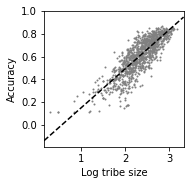

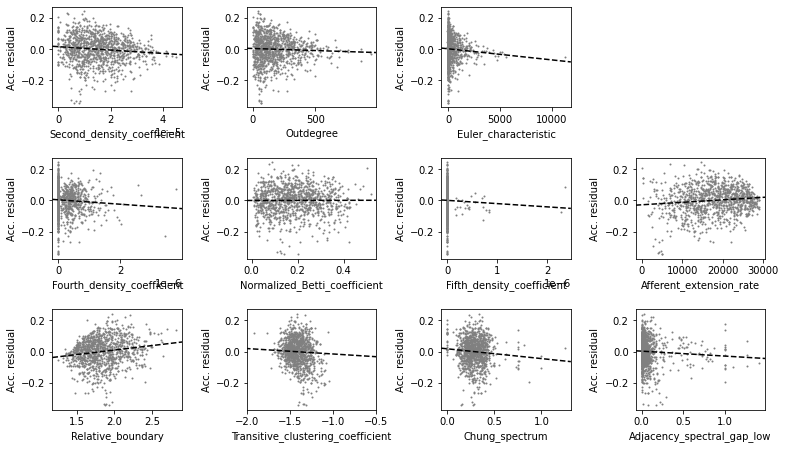

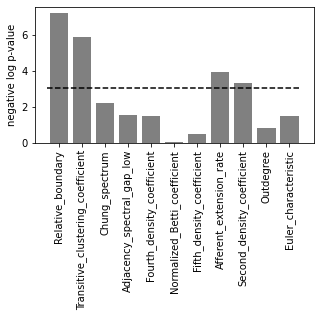

In [23]:
from pandas_helper import assemble_result_dataframe
from statsmodels.formula.api import ols

dframe_random_tribes = assemble_result_dataframe(tribe_nonpooled_mean_acc, tribe_struc_params,
                                                 sampling="M-type",
                                                 parameters_to_add=spec_parameters + ["Tribe size"])
display(dframe_random_tribes.head())

dframe_random_tribes["Log_tribe_size"] = numpy.log10(dframe_random_tribes["Tribe_size"])
model = ols("Accuracy ~ Log_tribe_size", data=dframe_random_tribes).fit()
dframe_random_tribes["Accuracy_residual"] = dframe_random_tribes["Accuracy"] - \
                                            model.predict(dframe_random_tribes)

fig = plt.figure(figsize=(2.5, 2.5))
ax = fig.gca()
ax.plot(dframe_random_tribes["Log_tribe_size"], dframe_random_tribes["Accuracy"], '.', ms=2, color='grey')
xx = ax.get_xlim()
ax.set_xlim(xx)
ax.plot(xx, model.params["Intercept"] + model.params["Log_tribe_size"] * numpy.array(xx),
        ls='--', color='black')
ax.set_xlabel("Log tribe size")
ax.set_ylabel("Accuracy")
S.save(fig, fn="Panel-B")

dframe_random_tribes.pop("Accuracy"); dframe_random_tribes.pop("Tribe_size");
dframe_random_tribes.pop("Log_tribe_size")

for col_name in ["Transitive_clustering_coefficient", "Relative_boundary"]:
    dframe_random_tribes[col_name] = numpy.log10(dframe_random_tribes[col_name] + 1E-8)

fig = plt.figure(figsize=(12, 7))
N = len(dframe_random_tribes.columns)
X = 4
p_vals = []; cols = []; i = 0
for col in dframe_random_tribes.columns:
    if col not in ["specifier", "Accuracy_residual"]:
        model = ols("Accuracy_residual ~ {0}".format(col), data=dframe_random_tribes).fit()
        pos_x = numpy.mod(i, X); pos_y = numpy.floor(i / X)
        i += 1
        ax = fig.add_axes([0.05 + pos_x * 0.225, 0.05 + pos_y * 0.3, 0.15, 0.2])
        ax.plot(dframe_random_tribes[col], dframe_random_tribes["Accuracy_residual"], '.', color='grey', ms=2)
        xx = ax.get_xlim()
        ax.set_xlim(xx)
        ax.plot(xx, model.params["Intercept"] + model.params[col] * numpy.array(xx), ls='--', color='black')
        p_vals.append(model.pvalues[col])
        cols.append(col)
        ax.set_xlabel(col)
        ax.set_ylabel("Acc. residual")
        if col == "Transitive_clustering_coefficient":
            ax.set_xlim([-2, -0.5])

S.save(fig, fn="Panel-C")
        
fig = plt.figure(figsize=(5, 2.5));
ax = fig.gca()
ax.bar(numpy.arange(len(cols)),
       -numpy.log10(p_vals),
      color='gray', width=0.8)
p_thresh = 0.01; p_thresh_corr = p_thresh / len(p_vals)
ax.plot([-0.5, len(p_vals) - 0.5],
       -numpy.log10(p_thresh_corr) * numpy.ones(2), color='black', ls='--')
ax.set_xticks(range(len(p_vals)))
_ = ax.set_xticklabels(cols, rotation='vertical')
ax.set_ylabel("negative log p-value")

F.save(fig, fn="Panel-C")

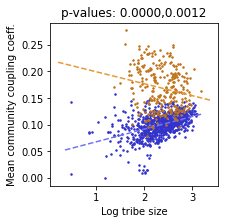

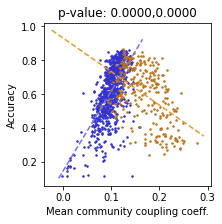

In [24]:
mtypes_l1_l5 = ['L1_DAC', 'L1_DLAC', 'L1_HAC', 'L1_NGC-DA', 'L1_NGC-SA', 'L1_SLAC', 'L23_BP', 'L23_BTC',
                   'L23_ChC', 'L23_DBC', 'L23_LBC', 'L23_MC', 'L23_NBC', 'L23_NGC', 'L23_PC', 'L23_SBC',
                   'L4_BP', 'L4_BTC', 'L4_ChC', 'L4_DBC', 'L4_LBC', 'L4_MC', 'L4_NBC', 'L4_NGC', 'L4_PC',
                   'L4_SBC', 'L4_SP', 'L4_SS', 'L5_BP', 'L5_BTC', 'L5_ChC', 'L5_DBC', 'L5_LBC', 'L5_MC',
                   'L5_NBC', 'L5_NGC', 'L5_SBC', 'L5_STPC', 'L5_TTPC1', 'L5_TTPC2', 'L5_UTPC']
mtypes_l6 = ['L6_BP', 'L6_BPC', 'L6_BTC', 'L6_ChC', 'L6_DBC', 'L6_IPC', 'L6_LBC', 'L6_MC', 'L6_NBC',
             'L6_NGC', 'L6_SBC', 'L6_TPC_L1', 'L6_TPC_L4', 'L6_UTPC']

dframe_tribes_coupl = assemble_result_dataframe(tribe_nonpooled_mean_acc, tribe_struc_params,
                                                 sampling="M-type", labels_to_iterate=mtypes_l1_l5,
                                                 parameters_to_add=spec_comm_coupling + ["Tribe size"])
dframe_tribes_coupl_l6 = assemble_result_dataframe(tribe_nonpooled_mean_acc, tribe_struc_params,
                                                   sampling="M-type", labels_to_iterate=mtypes_l6,
                                                   parameters_to_add=spec_comm_coupling + ["Tribe size"])

dframe_tribes_coupl["Log_tribe_size"] = numpy.log10(dframe_tribes_coupl["Tribe_size"])
dframe_tribes_coupl_l6["Log_tribe_size"] = numpy.log10(dframe_tribes_coupl_l6["Tribe_size"])


ax = plt.figure(figsize=(3, 3)).gca()
ax.plot(dframe_tribes_coupl["Log_tribe_size"],
        dframe_tribes_coupl["Mean_tribe_community_coupling"], '.', ms=3, color=[0.2, 0.2, 0.8])
model = ols("Mean_tribe_community_coupling ~ Log_tribe_size", data=dframe_tribes_coupl).fit()
ax.plot(ax.get_xlim(), model.params["Intercept"] +
        model.params["Log_tribe_size"] * numpy.array(ax.get_xlim()),
       ls='--', color=[0.45, 0.45, 0.95])

ax.plot(dframe_tribes_coupl_l6["Log_tribe_size"],
        dframe_tribes_coupl_l6["Mean_tribe_community_coupling"], '.', ms=3, color=[0.75, 0.45, 0.1])
model_l6 = ols("Mean_tribe_community_coupling ~ Log_tribe_size", data=dframe_tribes_coupl_l6).fit()
ax.plot(ax.get_xlim(), model_l6.params["Intercept"] +
        model_l6.params["Log_tribe_size"] * numpy.array(ax.get_xlim()),
       ls='--', color=[0.9, 0.6, 0.2])

ax.set_title("p-values: {0:5.4f},{1:5.4f}".format(model.pvalues["Log_tribe_size"],
                                       model_l6.pvalues["Log_tribe_size"]))
ax.set_xlabel("Log tribe size")
ax.set_ylabel("Mean community coupling coeff.")

F5.save(fig, fn="Panel-A")

###

ax = plt.figure(figsize=(3, 3)).gca()
ax.plot(dframe_tribes_coupl["Mean_tribe_community_coupling"],
        dframe_tribes_coupl["Accuracy"], '.', ms=3, color=[0.2, 0.2, 0.8])
model = ols("Accuracy ~ Mean_tribe_community_coupling", data=dframe_tribes_coupl).fit()
ax.plot(ax.get_xlim(), model.params["Intercept"] +
        model.params["Mean_tribe_community_coupling"] * numpy.array(ax.get_xlim()),
       ls='--', color=[0.45, 0.45, 0.95])

ax.plot(dframe_tribes_coupl_l6["Mean_tribe_community_coupling"],
        dframe_tribes_coupl_l6["Accuracy"], '.', ms=3, color=[0.75, 0.45, 0.1])
model_l6 = ols("Accuracy ~ Mean_tribe_community_coupling", data=dframe_tribes_coupl_l6).fit()
ax.plot(ax.get_xlim(), model_l6.params["Intercept"] +
        model_l6.params["Mean_tribe_community_coupling"] * numpy.array(ax.get_xlim()),
       ls='--', color=[0.9, 0.6, 0.2])

ax.set_title("p-value: {0:5.4f},{1:5.4f}".format(model.pvalues["Mean_tribe_community_coupling"],
                                      model_l6.pvalues["Mean_tribe_community_coupling"]))
ax.set_xlabel("Mean community coupling coeff.")
ax.set_ylabel("Accuracy")

F5.save(fig, fn="Panel-B")

,specifier,Accuracy,Mean_tribe_community_coupling,Relative_boundary,Transitive_clustering_coefficient,Afferent_extension_rate,Second_density_coefficient,Euler_characteristic
0,125 um,0.409714,0.090156,35.840165,0.031506,24907.405471,0.000026,1262.353161
1,125 um,0.601872,0.091593,33.973113,0.032245,25510.384200,0.000028,1819.585008
2,125 um,0.587041,0.116518,33.894950,0.031293,24985.009013,0.000028,1566.854134
3,125 um,0.750463,0.130952,32.242842,0.033523,25999.262089,0.000034,2698.696613
4,125 um,0.401928,0.072560,35.488227,0.031453,24474.592100,0.000027,1482.157632
...,...,...,...,...,...,...,...,...
95,175 um,0.497683,0.079993,34.212220,0.031521,25154.387029,0.000027,1464.882284
96,175 um,0.628754,0.093329,33.148479,0.031484,24781.455704,0.000029,1956.146669
97,175 um,0.846496,0.131320,29.245952,0.033227,26755.238645,0.000037,4138.696837
98,175 um,0.826937,0.133666,31.478226,0.031497,24647.915676,0.000030,2372.813036


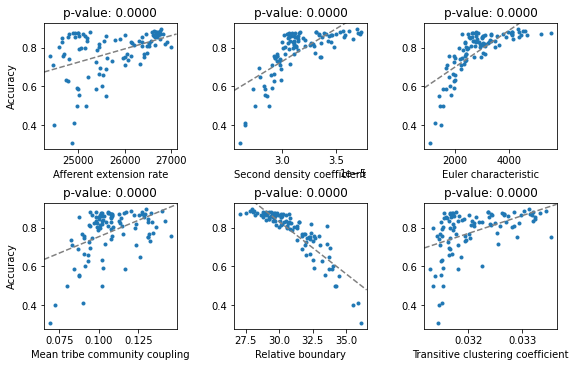

In [26]:
parameters_to_check = ["Mean tribe community coupling",
                      "Relative boundary",
                      "Transitive clustering coefficient",
                      "Afferent extension rate",
                      "Second density coefficient",
                      "Euler characteristic"]

dframe_vol_coupl = assemble_result_dataframe(tribe_nonpooled_mean_acc, tribe_struc_params,
                                             sampling="Radius",
                                             parameters_to_add=parameters_to_check)
display(dframe_vol_coupl)
fig = plt.figure(figsize=(8, 5))
i=1
for i, param in enumerate(parameters_to_check):
    san_param = param.replace(" ", "_")
    x = numpy.mod(i, 3); y = numpy.floor(i / 3)
    ax = fig.add_axes([0.05 + x * 0.33, 0.05 + y * 0.5, 0.23, 0.35])
    ax.plot(dframe_vol_coupl[san_param],
            dframe_vol_coupl["Accuracy"], '.')
    ax.set_ylim(ax.get_ylim()); ax.set_xlim(ax.get_xlim())
    model = ols("Accuracy ~ {0}".format(san_param), data=dframe_vol_coupl).fit()
    ax.plot(ax.get_xlim(), model.params["Intercept"] +
            model.params[san_param] * numpy.array(ax.get_xlim()),
            ls='--', color="gray")
    ax.set_xlabel(param)
    ax.set_title("p-value: {0:5.4f}".format(model.pvalues[san_param]))
    if i in [0, 3]:
        ax.set_ylabel("Accuracy")

F.save(fig, fn="Panel-D")